# 财务舞弊识别 - LightGBM模型训练与评估

本Notebook将使用预处理后的`reduced_data.csv`数据集，训练LightGBM模型进行财务舞弊识别。我们将执行以下步骤：
1. 数据加载与探索
2. 数据分割与预处理
3. 基础LightGBM模型训练
4. 超参数优化
5. 模型评估与可视化
6. 特征重要性分析
7. 结论与建议

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from collections import Counter
import time
import warnings
warnings.filterwarnings('ignore')

## 1. 数据加载与探索

In [11]:
data = pd.read_csv('reduced_data.csv')

## 2. 数据分割与预处理

In [12]:
# 准备特征和目标变量
X = data.drop(['Stkcd', 'Accper', 'Typrep ', 'isviolation'], axis=1)
y = data['isviolation']

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
# 使用SMOTE处理类别不平衡
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print('SMOTE处理后的训练集形状:', X_train_resampled.shape)
print('SMOTE处理后的训练集类别分布:')
print(Counter(y_train_resampled))

SMOTE处理后的训练集形状: (162916, 27)
SMOTE处理后的训练集类别分布:
Counter({1: 81458, 0: 81458})


## 3. 基础LightGBM模型训练

In [14]:
# 定义基础LightGBM模型
base_model = lgb.LGBMClassifier(
    random_state=42,
    objective='binary',
    metric='auc'
)

# 训练基础模型
start_time = time.time()
base_model.fit(X_train_resampled, y_train_resampled)
base_training_time = time.time() - start_time

# 在测试集上进行预测
y_pred_base = base_model.predict(X_test)
y_pred_prob_base = base_model.predict_proba(X_test)[:, 1]

# 评估基础模型性能
base_accuracy = accuracy_score(y_test, y_pred_base)
base_precision = precision_score(y_test, y_pred_base)
base_recall = recall_score(y_test, y_pred_base)
base_f1 = f1_score(y_test, y_pred_base)
base_auc = roc_auc_score(y_test, y_pred_prob_base)

print('基础模型性能评估:')
print(f'训练时间: {base_training_time:.2f}秒')
print(f'准确率: {base_accuracy:.4f}')
print(f'精确率: {base_precision:.4f}')
print(f'召回率: {base_recall:.4f}')
print(f'F1分数: {base_f1:.4f}')
print(f'AUC分数: {base_auc:.4f}')

[LightGBM] [Info] Number of positive: 81458, number of negative: 81458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6138
[LightGBM] [Info] Number of data points in the train set: 162916, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
基础模型性能评估:
训练时间: 0.70秒
准确率: 0.6586
精确率: 0.2368
召回率: 0.6110
F1分数: 0.3413
AUC分数: 0.6994


## 4. 超参数优化

In [19]:
# 定义LightGBM的参数网格
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0]
}

# 定义有限的参数网格（用于演示）
param_grid_limited = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

In [20]:
# 使用StratifiedKFold进行交叉验证
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 定义LightGBM分类器
lgb_model = lgb.LGBMClassifier(
    random_state=42,
    objective='binary',
    metric='auc'
)

# 使用RandomizedSearchCV进行超参数优化
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    n_iter=50,  # 采样50个参数组合
    cv=skf,
    scoring='roc_auc',
    random_state=42,
    verbose=2,
    n_jobs=-1
)

# 执行超参数优化
start_time = time.time()
random_search.fit(X_train_resampled, y_train_resampled)
optimization_time = time.time() - start_time

# 输出最佳参数和分数
print('超参数优化完成!')
print(f'优化时间: {optimization_time:.2f}秒')
print('最佳参数:')
for param, value in random_search.best_params_.items():
    print(f'  {param}: {value}')

print(f'最佳交叉验证分数 (ROC AUC): {random_search.best_score_:.4f}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 81458, number of negative: 81458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6138
[LightGBM] [Info] Number of data points in the train set: 162916, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
超参数优化完成!
优化时间: 514.48秒
最佳参数:
  subsample: 1.0
  reg_lambda: 0.0
  reg_alpha: 0.0
  n_estimators: 500
  min_child_weight: 7
  max_depth: 9
  learning_rate: 0.2
  colsample_bytree: 0.9
最佳交叉验证分数 (ROC AUC): 0.8730


In [21]:
# 使用最佳参数训练最终模型
best_params = random_search.best_params_
best_model = lgb.LGBMClassifier(
    **best_params,
    random_state=42,
    objective='binary',
    metric='auc'
)

# 训练最终模型
best_model.fit(X_train_resampled, y_train_resampled)

# 在测试集上进行预测
y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 81458, number of negative: 81458
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6138
[LightGBM] [Info] Number of data points in the train set: 162916, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


## 5. 模型评估与可视化

In [22]:
# 评估最终模型性能
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print('最终模型性能评估:')
print(f'准确率: {accuracy:.4f}')
print(f'精确率: {precision:.4f}')
print(f'召回率: {recall:.4f}')
print(f'F1分数: {f1:.4f}')
print(f'AUC分数: {auc:.4f}')

# 打印详细分类报告
print('分类报告:')
print(classification_report(y_test, y_pred))

最终模型性能评估:
准确率: 0.7320
精确率: 0.2865
召回率: 0.5715
F1分数: 0.3817
AUC分数: 0.7376
分类报告:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83     20365
           1       0.29      0.57      0.38      3447

    accuracy                           0.73     23812
   macro avg       0.60      0.67      0.61     23812
weighted avg       0.82      0.73      0.76     23812



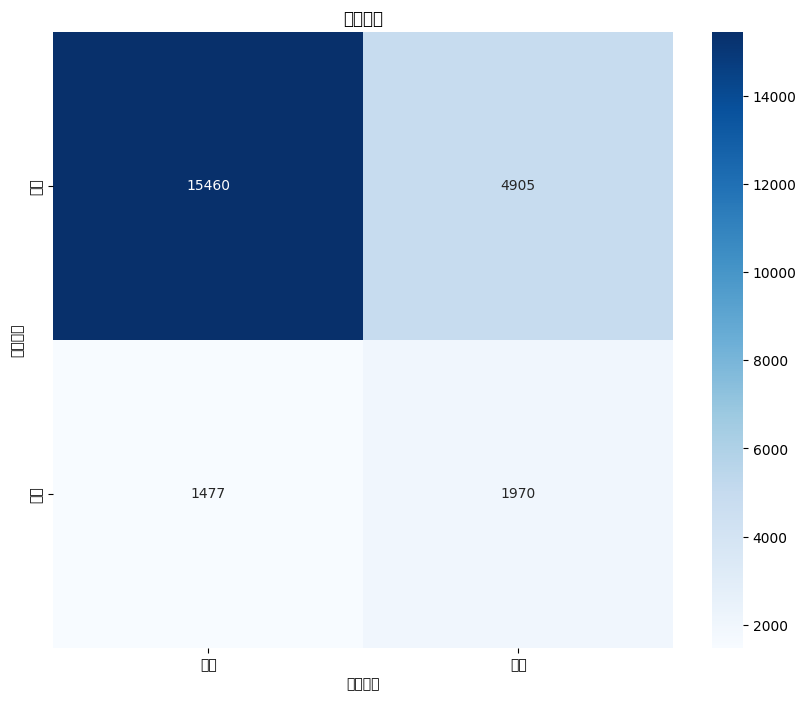

In [23]:
# 绘制混淆矩阵
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['正常', '舞弊'],
            yticklabels=['正常', '舞弊'])
plt.title('混淆矩阵')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.show()

## 6. 特征重要性分析

In [26]:
# 获取特征重要性
feature_importance = best_model.feature_importances_
feature_names = X.columns

# 创建特征重要性DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# 按重要性降序排序
importance_df = importance_df.sort_values('Importance', ascending=False)

print('特征重要性（前15个）:')
print(importance_df.head(15))

特征重要性（前15个）:
   Feature  Importance
0     year        1008
26  pca_24         939
3    pca_1         754
19  pca_17         687
5    pca_3         677
25  pca_23         654
24  pca_22         635
11   pca_9         629
22  pca_20         616
10   pca_8         602
13  pca_11         599
20  pca_18         589
21  pca_19         575
8    pca_6         530
16  pca_14         515


## 7. 模型保存

In [ ]:
# 保存最佳模型
import joblib

# 保存模型到文件
model_filename = 'lightgbm_fraud_detection_model.pkl'
joblib.dump(best_model, model_filename)


print(f'模型已保存到: {model_filename}')

模型已保存到: lightgbm_fraud_detection_model.pkl
特征重要性结果已保存到: feature_importance_results.csv


## 8. 结论与建议

In [30]:
# 性能对比总结
results_df = pd.DataFrame({
    '评估指标': ['准确率', '精确率', '召回率', 'F1分数', 'AUC分数'],
    '基础模型': [base_accuracy, base_precision, base_recall, base_f1, base_auc],
    '优化模型': [accuracy, precision, recall, f1, auc]
})

print('模型性能对比:')
print(results_df.round(4))

模型性能对比:
    评估指标    基础模型                                  优化模型
0    准确率  0.6586                              0.731984
1    精确率  0.2368                              0.286545
2    召回率  0.6110                              0.571511
3   F1分数  0.3413                              0.381709
4  AUC分数  0.6994  <function auc at 0x0000014A530C8D60>
